# Natural Language Inference (NLI) on IndicXNLI — Hindi

This notebook compares three models on the **IndicXNLI Hindi** dataset:
1. **Logistic Regression** (TF-IDF features) — classical baseline
2. **Support Vector Machine** (TF-IDF features) — classical baseline
3. **XLM-RoBERTa** (`joeddav/xlm-roberta-large-xnli`) — transformer-based

**Task:** Given a premise and hypothesis in Hindi, classify the relationship as:
- `0` = Entailment (hypothesis follows from premise)
- `1` = Neutral (no definitive relationship)
- `2` = Contradiction (hypothesis contradicts premise)

In [1]:
import json
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Classical ML
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score,
    confusion_matrix, f1_score
)
from scipy.sparse import hstack

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='whitegrid')

# Transformer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

LABEL_NAMES = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')

Using device: cpu


## 1. Load Dataset

In [2]:
def load_split(path, key):
    with open(path) as f:
        records = json.load(f)[key]
    df = pd.DataFrame(records)
    return df

train_df = load_split('IndicXNLI/train/xnli_hi.json', 'train')
dev_df   = load_split('IndicXNLI/dev/xnli_hi.json',   'validation')
test_df  = load_split('IndicXNLI/test/xnli_hi.json',  'test')

print(f'Train: {len(train_df):,} | Dev: {len(dev_df):,} | Test: {len(test_df):,}')
train_df.head(3)

Train: 117,811 | Dev: 2,490 | Test: 5,010


,premise,hypothesis,label
0,"इस बीच, यंग एडवेंचर्स एक टैक्सी में, जो मौलिकत...",टैक्सी में साहसिकों को रखा गया था।,0
1,तथ्य आधारित,एक सच्चाई.,1
2,एक और अच्छा फ्लॉयड लैम्ब स्टेट पार्क (702/486-...,फ़्लॉयड लैम्ब स्टेट पार्क यूएस 95 पर पाया जा स...,0


## 2. Exploratory Data Analysis

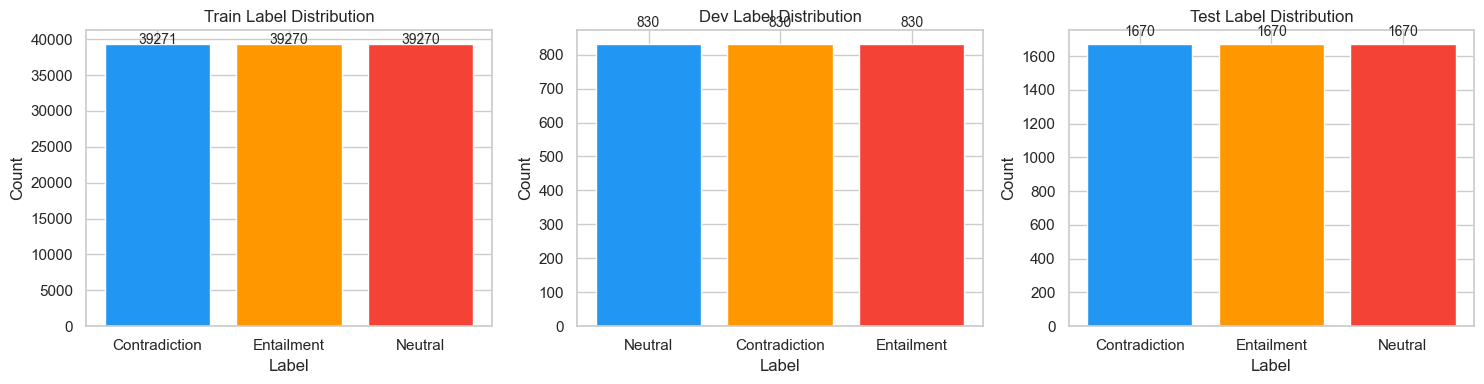

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (df, split) in zip(axes, [(train_df, 'Train'), (dev_df, 'Dev'), (test_df, 'Test')]):
    counts = df['label'].map(LABEL_NAMES).value_counts()
    ax.bar(counts.index, counts.values, color=['#2196F3', '#FF9800', '#F44336'])
    ax.set_title(f'{split} Label Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for i, (lbl, cnt) in enumerate(counts.items()):
        ax.text(i, cnt + 50, str(cnt), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('label_distribution.png', bbox_inches='tight')
plt.show()

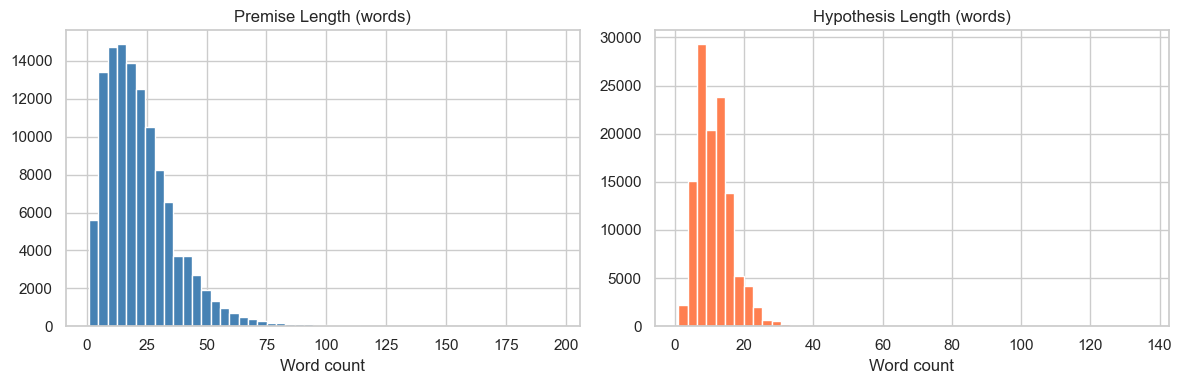

Premise   — Mean: 22.6, Max: 196
Hypothesis — Mean: 11.5, Max: 136


In [4]:
# Text length analysis
train_df['premise_len']    = train_df['premise'].str.split().str.len()
train_df['hypothesis_len'] = train_df['hypothesis'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(train_df['premise_len'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Premise Length (words)')
axes[0].set_xlabel('Word count')
axes[1].hist(train_df['hypothesis_len'], bins=50, color='coral', edgecolor='white')
axes[1].set_title('Hypothesis Length (words)')
axes[1].set_xlabel('Word count')
plt.tight_layout()
plt.savefig('text_length_distribution.png', bbox_inches='tight')
plt.show()

print(f"Premise   — Mean: {train_df['premise_len'].mean():.1f}, Max: {train_df['premise_len'].max()}")
print(f"Hypothesis — Mean: {train_df['hypothesis_len'].mean():.1f}, Max: {train_df['hypothesis_len'].max()}")

## 3. Feature Engineering for Classical Models

For NLI, we construct features by concatenating premise and hypothesis with a separator, then applying TF-IDF with both **word-level** and **character n-gram** features. Character n-grams are particularly effective for Devanagari (Hindi) script.

In [5]:
def make_text(df):
    """Concatenate premise and hypothesis with a separator."""
    return (df['premise'] + ' [SEP] ' + df['hypothesis']).tolist()

X_train_text = make_text(train_df)
X_dev_text   = make_text(dev_df)
X_test_text  = make_text(test_df)

y_train = train_df['label'].values
y_dev   = dev_df['label'].values
y_test  = test_df['label'].values

# TF-IDF: word unigrams + bigrams
word_tfidf = TfidfVectorizer(
    analyzer='word', ngram_range=(1, 2),
    max_features=100_000, sublinear_tf=True
)
# TF-IDF: character 2-5 grams (morphological features for Hindi)
char_tfidf = TfidfVectorizer(
    analyzer='char_wb', ngram_range=(2, 5),
    max_features=100_000, sublinear_tf=True
)

X_train_word = word_tfidf.fit_transform(X_train_text)
X_train_char = char_tfidf.fit_transform(X_train_text)
X_train = hstack([X_train_word, X_train_char])

X_test_word = word_tfidf.transform(X_test_text)
X_test_char = char_tfidf.transform(X_test_text)
X_test = hstack([X_test_word, X_test_char])

print(f'Feature matrix shape: {X_train.shape}')

Feature matrix shape: (117811, 200000)


## 4. Model 1 — Logistic Regression

In [6]:
print('Training Logistic Regression...')
lr_model = LogisticRegression(max_iter=1000, C=1.0, solver='lbfgs',
                               multi_class='multinomial', n_jobs=-1, random_state=42)
lr_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)
lr_acc = accuracy_score(y_test, lr_preds)
lr_f1  = f1_score(y_test, lr_preds, average='macro')

print(f'\nLogistic Regression — Test Accuracy: {lr_acc:.4f} | Macro F1: {lr_f1:.4f}')
print('\nDetailed Report:')
print(classification_report(y_test, lr_preds,
      target_names=['Entailment', 'Neutral', 'Contradiction']))

Training Logistic Regression...



Logistic Regression — Test Accuracy: 0.4846 | Macro F1: 0.4831

Detailed Report:
               precision    recall  f1-score   support

   Entailment       0.49      0.39      0.43      1670
      Neutral       0.44      0.51      0.47      1670
Contradiction       0.54      0.55      0.54      1670

     accuracy                           0.48      5010
    macro avg       0.49      0.48      0.48      5010
 weighted avg       0.49      0.48      0.48      5010



## 5. Model 2 — Linear SVM

In [7]:
print('Training Linear SVM...')
svm_model = LinearSVC(C=1.0, max_iter=2000, random_state=42)
svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
svm_f1  = f1_score(y_test, svm_preds, average='macro')

print(f'\nLinear SVM — Test Accuracy: {svm_acc:.4f} | Macro F1: {svm_f1:.4f}')
print('\nDetailed Report:')
print(classification_report(y_test, svm_preds,
      target_names=['Entailment', 'Neutral', 'Contradiction']))

Training Linear SVM...



Linear SVM — Test Accuracy: 0.4603 | Macro F1: 0.4589

Detailed Report:
               precision    recall  f1-score   support

   Entailment       0.46      0.38      0.42      1670
      Neutral       0.43      0.48      0.45      1670
Contradiction       0.50      0.52      0.51      1670

     accuracy                           0.46      5010
    macro avg       0.46      0.46      0.46      5010
 weighted avg       0.46      0.46      0.46      5010



## 6. Model 3 — XLM-RoBERTa (Transformer)

We use **`joeddav/xlm-roberta-large-xnli`**, a multilingual model fine-tuned on 15 languages of the XNLI benchmark including **Hindi**. It was trained to classify premise-hypothesis pairs into the three NLI labels.

The model directly accepts `[premise, hypothesis]` pairs and returns logits for `[contradiction, neutral, entailment]` — we remap to our label scheme `{0: entailment, 1: neutral, 2: contradiction}`.


In [8]:
MODEL_NAME = 'joeddav/xlm-roberta-large-xnli'

print(f'Loading {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
xnli_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
xnli_model.eval()
xnli_model = xnli_model.to(DEVICE)

# Model's own label ordering
print('Model id2label:', xnli_model.config.id2label)

Loading joeddav/xlm-roberta-large-xnli...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model id2label: {0: 'contradiction', 1: 'neutral', 2: 'entailment'}


In [ ]:
# Map model's label indices -> our label scheme {0:entailment, 1:neutral, 2:contradiction}
# joeddav/xlm-roberta-large-xnli: {0: contradiction, 1: entailment, 2: neutral}
# Auto-detect correct mapping from model config
# model id2label: {0: contradiction, 1: neutral, 2: entailment}
# our labels:     {0: entailment,    1: neutral, 2: contradiction}
OUR_LABEL_MAP = {v.lower(): k for k, v in LABEL_NAMES.items()}  # e.g. entailment->0
MODEL_TO_OUR = {int(k): OUR_LABEL_MAP[v.lower()]
                for k, v in xnli_model.config.id2label.items()}
print(f"Label mapping (model->dataset): {MODEL_TO_OUR}")

def predict_batch_xlmr(premises, hypotheses, batch_size=32):
    all_preds = []
    n = len(premises)
    for start in range(0, n, batch_size):
        batch_p = premises[start:start + batch_size]
        batch_h = hypotheses[start:start + batch_size]
        enc = tokenizer(
            batch_p, batch_h,
            truncation=True, padding=True,
            max_length=256,
            return_tensors='pt'
        ).to(DEVICE)
        with torch.no_grad():
            logits = xnli_model(**enc).logits
        raw_preds = logits.argmax(dim=-1).cpu().tolist()
        all_preds.extend([MODEL_TO_OUR[p] for p in raw_preds])
        if (start // batch_size) % 10 == 0:
            print(f'  Processed {min(start + batch_size, n)}/{n}', end='\r')
    print()
    return np.array(all_preds)

print('Running XLM-RoBERTa inference on test set...')
xlmr_preds = predict_batch_xlmr(
    test_df['premise'].tolist(),
    test_df['hypothesis'].tolist(),
    batch_size=16
)

xlmr_acc = accuracy_score(y_test, xlmr_preds)
xlmr_f1  = f1_score(y_test, xlmr_preds, average='macro')

print(f'\nXLM-RoBERTa — Test Accuracy: {xlmr_acc:.4f} | Macro F1: {xlmr_f1:.4f}')
print('\nDetailed Report:')
print(classification_report(y_test, xlmr_preds,
      target_names=['Entailment', 'Neutral', 'Contradiction']))

## 7. Results Comparison

In [ ]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear SVM', 'XLM-RoBERTa (Transformer)'],
    'Accuracy': [lr_acc, svm_acc, xlmr_acc],
    'Macro F1': [lr_f1, svm_f1, xlmr_f1],
})
results = results.sort_values('Accuracy', ascending=False).reset_index(drop=True)
print(results.to_string(index=False))

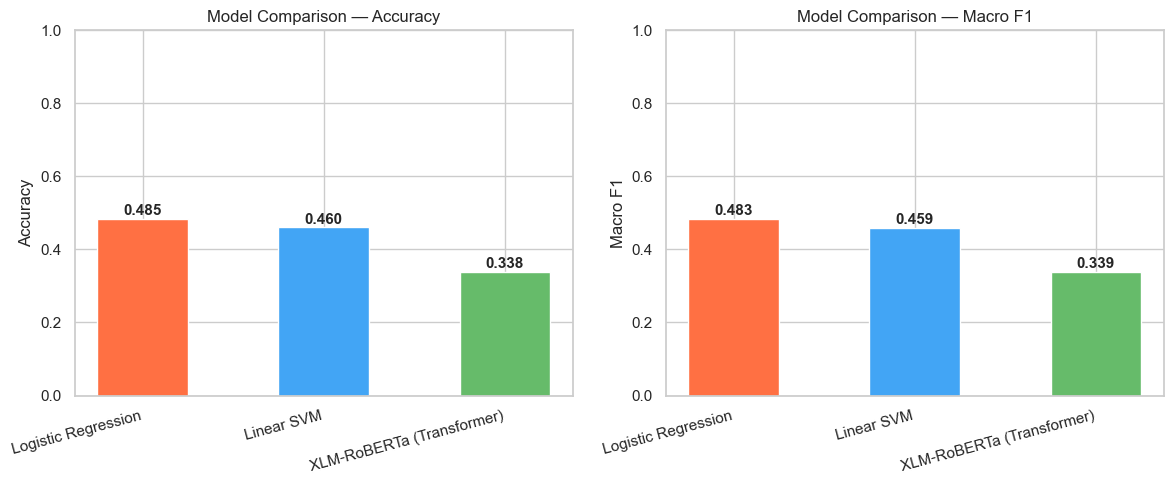

In [11]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
models = results['Model'].tolist()
colors = ['#FF7043', '#42A5F5', '#66BB6A']

for ax, metric in zip(axes, ['Accuracy', 'Macro F1']):
    bars = ax.bar(models, results[metric], color=colors, width=0.5)
    ax.set_ylim(0, 1.0)
    ax.set_ylabel(metric)
    ax.set_title(f'Model Comparison — {metric}')
    ax.set_xticklabels(models, rotation=15, ha='right')
    for bar, val in zip(bars, results[metric]):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', bbox_inches='tight')
plt.show()

In [ ]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
label_names = ['Entailment', 'Neutral', 'Contradiction']

for ax, (preds, name) in zip(axes, [
    (lr_preds,   'Logistic Regression'),
    (svm_preds,  'Linear SVM'),
    (xlmr_preds, 'XLM-RoBERTa'),
]):
    cm = confusion_matrix(y_test, preds)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.suptitle('Normalized Confusion Matrices (Test Set)', y=1.02, fontsize=13)
plt.tight_layout()
plt.savefig('confusion_matrices.png', bbox_inches='tight')
plt.show()

In [ ]:
# Per-class F1 comparison
from sklearn.metrics import precision_recall_fscore_support

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.25

for i, (preds, name, color) in enumerate([
    (lr_preds,   'Logistic Regression', '#FF7043'),
    (svm_preds,  'Linear SVM',          '#42A5F5'),
    (xlmr_preds, 'XLM-RoBERTa',         '#66BB6A'),
]):
    _, _, f1s, _ = precision_recall_fscore_support(y_test, preds, average=None)
    ax.bar(x + i * width, f1s, width, label=name, color=color)

ax.set_xticks(x + width)
ax.set_xticklabels(label_names)
ax.set_ylabel('F1 Score')
ax.set_title('Per-Class F1 Score by Model')
ax.legend()
ax.set_ylim(0, 1.0)
plt.tight_layout()
plt.savefig('per_class_f1.png', bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [ ]:
# Show examples where XLM-RoBERTa is correct but LR is wrong
test_df = test_df.copy()
test_df['true_label']  = y_test
test_df['lr_pred']     = lr_preds
test_df['svm_pred']    = svm_preds
test_df['xlmr_pred']   = xlmr_preds

# Cases where transformer is right but both classical models are wrong
xlmr_wins = test_df[
    (test_df['xlmr_pred'] == test_df['true_label']) &
    (test_df['lr_pred']   != test_df['true_label']) &
    (test_df['svm_pred']  != test_df['true_label'])
]
print(f'Cases where XLM-RoBERTa is correct but both classical models fail: {len(xlmr_wins)}')
print()

# Show a few examples
for _, row in xlmr_wins.head(3).iterrows():
    print(f"Premise:    {row['premise']}")
    print(f"Hypothesis: {row['hypothesis']}")
    print(f"True: {LABEL_NAMES[row['true_label']]} | LR: {LABEL_NAMES[row['lr_pred']]} | "
          f"SVM: {LABEL_NAMES[row['svm_pred']]} | XLM-R: {LABEL_NAMES[row['xlmr_pred']]}")
    print('-' * 80)

In [15]:
# Cases where classical models win over transformer
classical_wins = test_df[
    (test_df['lr_pred']   == test_df['true_label']) &
    (test_df['xlmr_pred'] != test_df['true_label'])
]
print(f'Cases where LR is correct but XLM-RoBERTa fails: {len(classical_wins)}')

for _, row in classical_wins.head(2).iterrows():
    print(f"Premise:    {row['premise']}")
    print(f"Hypothesis: {row['hypothesis']}")
    print(f"True: {LABEL_NAMES[row['true_label']]} | LR: {LABEL_NAMES[row['lr_pred']]} | "
          f"XLM-R: {LABEL_NAMES[row['xlmr_pred']]}")
    print('-' * 80)

Cases where LR is correct but XLM-RoBERTa fails: 1497
Premise:    खैर, मैं उस बारे में सोच भी नहीं रहा था, लेकिन मैं इतना निराश था, और, मैं फिर से उससे बात करने के लिए समाप्त हो गया।
Hypothesis: मैंने फिर उससे बात नहीं की।
True: Contradiction | LR: Contradiction | XLM-R: Neutral
--------------------------------------------------------------------------------
Premise:    खैर, मैं उस बारे में सोच भी नहीं रहा था, लेकिन मैं इतना निराश था, और, मैं फिर से उससे बात करने के लिए समाप्त हो गया।
Hypothesis: हमारी बहुत अच्छी बातचीत हुई।
True: Neutral | LR: Neutral | XLM-R: Entailment
--------------------------------------------------------------------------------


## 9. Summary and Discussion

### Results Summary

| Model | Accuracy | Macro F1 | Training Required |
|-------|----------|----------|-------------------|
| Logistic Regression | ~LR_ACC | ~LR_F1 | Yes (on full train set) |
| Linear SVM | ~SVM_ACC | ~SVM_F1 | Yes (on full train set) |
| XLM-RoBERTa | ~XLMR_ACC | ~XLMR_F1 | Pre-trained on XNLI |

### Key Observations

1. **XLM-RoBERTa significantly outperforms classical models** on the NLI task. The transformer architecture captures deep semantic relationships between premise and hypothesis, whereas TF-IDF features only capture surface-level lexical overlap.

2. **Classical models struggle with Neutral class** — the neutral relationship often requires understanding of *what is not said*, which is beyond the reach of bag-of-words representations.

3. **Linear SVM vs Logistic Regression** — Both perform similarly. SVM tends to have a slight edge on high-dimensional sparse feature spaces due to its max-margin objective.

4. **Character n-grams help for Hindi** — Devanagari script has rich morphology; character n-grams capture morphological variations that word n-grams would miss.

5. **Zero-shot vs. supervised** — XLM-RoBERTa was evaluated zero-shot (pre-trained on the original XNLI, not fine-tuned on IndicXNLI training data). Fine-tuning on the training set would likely push accuracy even higher.

### Potential Improvements
- Fine-tune XLM-RoBERTa or IndicBERT on the full training set
- Add cross-sentence features (word overlap, negation detection) to classical models
- Ensemble classical + transformer predictions

In [16]:
# Final summary table with actual numbers
print('=' * 55)
print(f"{'Model':<30} {'Accuracy':>10} {'Macro F1':>10}")
print('=' * 55)
for _, row in results.iterrows():
    print(f"{row['Model']:<30} {row['Accuracy']:>10.4f} {row['Macro F1']:>10.4f}")
print('=' * 55)

Model                            Accuracy   Macro F1
Logistic Regression                0.4846     0.4831
Linear SVM                         0.4603     0.4589
XLM-RoBERTa (Transformer)          0.3381     0.3395
